In [1]:
import matplotlib
matplotlib.use('Qt4Agg')
matplotlib.interactive(True)

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
all_present = mep_present and eeg_present and cmap_present
print(all_present)

True


In [ ]:
print('EEG count: ' + str(len(eegs)))
print('MEP count: ' + str(len(meps)))
print('CMAP count: ' + str(len(cmaps)))

In [ ]:
eegs

In [ ]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [ ]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Calculate EEG area.
def calculate_eeg_area(epoch_df, sf=2048):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    b2, a2 = signal.butter(4, 200/(sf/2), btype='lowpass')
    envelope = signal.filtfilt(b2, a2, np.abs(y))
    area = np.trapz(envelope, epoch_df['time'].values)
    return area

# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

def band_max(freq, psd, start=0, end=4):
    indices = np.where((freq >= start) & (freq <= end))
    freq = freq[indices]
    psd = psd[indices]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

def read_wavelets(eeg_path, epoch_num):
    segments = eeg_path.split('/')
    path = 'wavelets/' + segments[2] + '-' + segments[3] + '-' + segments[5] + '-' + str(epoch_num)
    with open(path + '-central.pickle', 'rb') as f:
        central = pickle.load(f)
    with open(path + '-ltm1.pickle', 'rb') as f:
        ltm1 = pickle.load(f)
    with open(path + '-rtm1.pickle', 'rb') as f:
        rtm1 = pickle.load(f)
    with open(path + '-all.pickle', 'rb') as f:
        all_channels = pickle.load(f)
    return all_channels, ltm1, rtm1, central

# Read and process MEP

In [ ]:
def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

def get_cmap_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'cmap'
    del segments[5]
    segments = segments[:-1]
    cmap_path = '/'.join(segments) + '/*.xlsx'
    cmap_paths = glob.glob(cmap_path)
    if (len(cmap_paths) == 0):
        print('No CMAP found for ' + cmap_path)
        return ''
    return cmap_paths[0]

def mep_area(mep):
    mep, _ = crop_mep_region(mep)
    b2, a2 = signal.butter(4, 250/(3750/2), btype='lowpass')
    emg_envelope = signal.filtfilt(b2, a2, np.abs(mep[get_apb_column_name(mep)]))
    return np.trapz(np.abs(emg_envelope), np.linspace(1, mep.shape[0], mep.shape[0]))

def calculate_mep_categories(mep_frames):
    sizes = []
    for mep_frame in mep_frames:
        sizes.append(calculate_mep_size(mep_frame))
    p1 = np.percentile(sizes, 33.33)
    p2 = np.percentile(sizes, 66.66)
    cat = np.ones(len(mep_frames)) * ((sizes >= p1) & (sizes < p2))
    cat = 2 * (sizes >= p2) * np.ones(len(mep_frames)) + cat
    return cat

# Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

# Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

# Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

# Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

def get_mep_category_absolute(mep_size):
    if mep_size <= .2:
        return 0
    elif mep_size > .2 and mep_size < 1:
        return 1
    else:
        return 2

# Read and process CMAP

In [ ]:
# Read CMAP file.
def read_cmap(path):
    df = pd.read_excel(path, sheet_name='Raw data', header=None)
    cmap = df.iloc[44:df.shape[0]-1, 38:59]
    time = df.iloc[44:df.shape[0]-1, 0]
    df = pd.DataFrame(cmap)
    df['time'] = time
    return df

# Identify CMAP peaks.
def find_cmap_peaks(cmap):
    time = cmap['time']
    mean_clean = cmap.drop('time', axis=1).mean(axis=1)
    mean_clean[0:104*10-1] = 0
    idxmax = mean_clean.idxmax(axis=0)
    idxmax = time[idxmax]
    idxmin = mean_clean.idxmin(axis=0)
    idxmin = time[idxmin]
    max_val = mean_clean.max()
    min_val = mean_clean.min()
    return max_val, min_val

# Extract all features from EEG, CMAP and MEP

In [ ]:
def extract_features(eeg_path):
    mep_path = get_mep_path(eeg_path)
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_trials(epochs)
    mep_frames = open_mep_as_df(mep_path)
    epoch_features = []
    if len(epochs) != len(mep_frames):
        # print('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path + ' and ' + mep_path)
        raise Exception('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path + ' and ' + mep_path)
        return
    mep_sizes = calculate_mep_categories(mep_frames)
    for i in range(len(epochs)):
        epoch = epochs[i]
        mep = mep_frames[i]
        segments = eeg_path.split('/')
        d = {'sub': segments[2], 'exp': segments[3], 'run': segments[5], 'epoch': i}

        freq, psd = calculate_eeg_frequency(epoch.drop('time', axis=1).values.mean(axis=1))
        d['all_all_max_power_freq'], d['all_all_max_power'] = band_max(freq, psd, 4, 40)
        d['all_delta_max_power_freq'], d['all_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['all_theta_max_power_freq'], d['all_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['all_alpha_max_power_freq'], d['all_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['all_beta_max_power_freq'], d['all_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['all_gamma_max_power_freq'], d['all_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch, 'ltm1').drop('time', axis=1).values.mean(axis=1))
        d['ltm1_all_max_power_freq'], d['ltm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['ltm1_delta_max_power_freq'], d['ltm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['ltm1_theta_max_power_freq'], d['ltm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['ltm1_alpha_max_power_freq'], d['ltm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['ltm1_beta_max_power_freq'], d['ltm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['ltm1_gamma_max_power_freq'], d['ltm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch, 'rtm1').drop('time', axis=1).values.mean(axis=1))
        d['rtm1_all_max_power_freq'], d['rtm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['rtm1_delta_max_power_freq'], d['rtm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['rtm1_theta_max_power_freq'], d['rtm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['rtm1_alpha_max_power_freq'], d['rtm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['rtm1_beta_max_power_freq'], d['rtm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['rtm1_gamma_max_power_freq'], d['rtm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch, 'central').drop('time', axis=1).values.mean(axis=1))
        d['central_all_max_power_freq'], d['central_all_max_power'] = band_max(freq, psd, 4, 40)
        d['central_delta_max_power_freq'], d['central_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['central_theta_max_power_freq'], d['central_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['central_alpha_max_power_freq'], d['central_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['central_beta_max_power_freq'], d['central_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['central_gamma_max_power_freq'], d['central_gamma_max_power'] = band_max(freq, psd, 32, 500)
        
        # Wavelet
        wt_all, wt_ltm1, wt_rtm1, wt_central = read_wavelets(eeg_path, i)
        d['wavelet_all_max_power_at_freq'] = wt_all.mean(axis=1).argmax() * 1000
        d['wavelet_all_max_power_freq'] = wt_all.mean(axis=1).max()
        d['wavelet_ltm1_max_power_at_freq'] = wt_ltm1.mean(axis=1).argmax() * 1000
        d['wavelet_ltm1_max_power_freq'] = wt_ltm1.mean(axis=1).max()
        d['wavelet_rtm1_max_power_at_freq'] = wt_rtm1.mean(axis=1).argmax() * 1000
        d['wavelet_rtm1_max_power_freq'] = wt_rtm1.mean(axis=1).max()
        d['wavelet_central_max_power_at_freq'] = wt_central.mean(axis=1).argmax() * 1000
        d['wavelet_central_max_power_freq'] = wt_central.mean(axis=1).max()
        
        d['wavelet_all_max_power_at_time'] = wt_all.mean(axis=0).argmax()
        d['wavelet_all_max_power_time'] = wt_all.mean(axis=0).max()
        d['wavelet_ltm1_max_power_at_time'] = wt_ltm1.mean(axis=0).argmax()
        d['wavelet_ltm1_max_power_time'] = wt_ltm1.mean(axis=0).max()
        d['wavelet_rtm1_max_power_at_time'] = wt_rtm1.mean(axis=0).argmax()
        d['wavelet_rtm1_max_power_time'] = wt_rtm1.mean(axis=0).max()
        d['wavelet_central_max_power_at_time'] = wt_central.mean(axis=0).argmax()
        d['wavelet_central_max_power_time'] = wt_central.mean(axis=0).max()

        d['area_under_eeg'] = calculate_eeg_area(epoch)
        d['rtm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch, 'rtm1'))
        d['ltm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch, 'ltm1'))
        d['central_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch, 'central'))
        
        d['all_all_max_amplitude'] = calculate_eeg_max_amplitude(epoch.drop('time', axis=1))
        d['rtm1_all_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'rtm1').drop('time', axis=1))
        d['ltm1_all_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'ltm1').drop('time', axis=1))
        d['central_all_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'central').drop('time', axis=1))

        d['all_alpha_max_amplitude'] = calculate_eeg_max_amplitude(epoch.drop('time', axis=1))
        d['rtm1_alpha_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'rtm1').drop('time', axis=1))
        d['ltm1_alpha_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'ltm1').drop('time', axis=1))
        d['central_alpha_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'central').drop('time', axis=1))
        
        cmap_path = get_cmap_path(eeg_path)
        cmap = read_cmap(cmap_path)
        d['cmap_max'], d['cmap_min'] = find_cmap_peaks(cmap)
        
        mep_size = calculate_mep_size(mep)
        d['mep_size'] = mep_size
        d['mep_category_percentile'] = mep_sizes[i]
        d['mep_category_absolute'] = get_mep_category_absolute(mep_size)
        d['mep_category_cmap'] = mep_size / (d['cmap_max'] - d['cmap_min'])
        d['mep_area'] = mep_area(mep)
        
        epoch_features.append(d)
    return epoch_features

In [ ]:
def extract_and_save_features(eeg_path, filename):
    features = extract_features(eeg_path)
    features = pd.DataFrame(features)
    if os.path.isfile(filename):
        old_features = pd.read_excel(filename, index_col=0)
        features = old_features.append(features)
    features.to_excel(filename)

In [5]:
features_filename = '36-features.xlsx'

In [ ]:
for eeg_path in tqdm_notebook(eegs):
    extract_and_save_features(eeg_path, features_filename)

In [6]:
df = pd.read_excel(features_filename, index_col=0)

In [7]:
print(df.shape)
print(df.columns)

(1400, 87)
Index(['all_all_max_amplitude', 'all_all_max_power', 'all_all_max_power_freq',
       'all_alpha_max_amplitude', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg',
       'central_all_max_amplitude', 'central_all_max_power',
       'central_all_max_power_freq', 'central_alpha_max_amplitude',
       'central_alpha_max_power', 'central_alpha_max_power_freq',
       'central_area_under_eeg', 'central_beta_max_power',
       'central_beta_max_power_freq', 'central_delta_max_power',
       'central_delta_max_power_freq', 'central_gamma_max_power',
       'central_gamma_max_power_freq', 'central_theta_max_power',
       'central_theta_max_power_freq', 'cmap_max', 'cmap_min', 'epoch', 'exp',
       'ltm1_all_max_amplitude', 'ltm1_a

# Plot Frequency vs MEP Size

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df['wavelet_all_max_power_at_freq'], df['mep_size'], '.')
plt.xlabel('Scale - All channels')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['wavelet_ltm1_max_power_at_freq'], df['mep_size'], '.')
plt.xlabel('Scale - Ltm1')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['wavelet_rtm1_max_power_at_freq'], df['mep_size'], '.')
plt.xlabel('Scale - Rtm1')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['wavelet_ltm1_max_power_at_freq'], df['mep_size'], '.')
plt.xlabel('Scale - Central')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Size')

plt.figure(figsize=(8,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
df2 = df[df['mep_category_percentile'] == 0]
plt.plot(df2['wavelet_ltm1_max_power_at_freq'], df2['wavelet_ltm1_max_power_freq'], 'o', color='green')
df2 = df[df['mep_category_percentile'] == 1]
plt.plot(df2['wavelet_ltm1_max_power_at_freq'], df2['wavelet_ltm1_max_power_freq'], 'o', color='red')
df2 = df[df['mep_category_percentile'] == 2]
plt.plot(df2['wavelet_ltm1_max_power_at_freq'], df2['wavelet_ltm1_max_power_freq'], 'o', color='blue')
plt.xlabel('Wavelet Freq - Ltm1')
plt.ylabel('Power - Ltm1')
plt.title('PERCENTILE CATEGORY')


plt.subplot(1, 2, 2)
df2 = df[df['mep_category_absolute'] == 0]
plt.plot(df2['wavelet_ltm1_max_power_at_freq'], df2['wavelet_ltm1_max_power_freq'], 'o', color='green')
df2 = df[df['mep_category_absolute'] == 1]
plt.plot(df2['wavelet_ltm1_max_power_at_freq'], df2['wavelet_ltm1_max_power_freq'], 'o', color='red')
df2 = df[df['mep_category_absolute'] == 2]
plt.plot(df2['wavelet_ltm1_max_power_at_freq'], df2['wavelet_ltm1_max_power_freq'], 'o', color='blue')
plt.xlabel('Wavelet Freq - Ltm1')
plt.ylabel('Power - Ltm1')
plt.title('ABSOLUTE CATEGORY')

In [ ]:
# X, Y = np.meshgrid(df['wavelet_ltm1_max_scale'], df['wavelet_ltm1_max_power'])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_ltm1_max_power_at_freq'], df['wavelet_ltm1_max_power_freq'], np.abs(np.log(df['mep_category_cmap'])), c=df['mep_category_cmap'])
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Power - Ltm1')
ax.set_zlabel('MEP/CMAP');

In [ ]:
# X, Y = np.meshgrid(df['wavelet_ltm1_max_scale'], df['wavelet_ltm1_max_power'])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_ltm1_max_power_at_freq'], df['wavelet_ltm1_max_power_freq'], df['mep_category_absolute'], c=df['mep_category_absolute'])
ax.set_xlabel('Scale - Ltm1')
ax.set_ylabel('Power - Ltm1')
ax.set_zlabel('MEP - absolute');

In [ ]:
plt.figure(figsize=(7,4))
df2 = df[df['mep_category_percentile'] == 0]
plt.plot(df2['wavelet_rtm1_max_power_at_freq'], df2['wavelet_rtm1_max_power_freq'], 'o', color='green')
df2 = df[df['mep_category_percentile'] == 1]
plt.plot(df2['wavelet_rtm1_max_power_at_freq'], df2['wavelet_rtm1_max_power_freq'], 'o', color='red')
df2 = df[df['mep_category_percentile'] == 2]
plt.plot(df2['wavelet_rtm1_max_power_at_freq'], df2['wavelet_rtm1_max_power_freq'], 'o', color='blue')
plt.xlabel('Wavelet Scale - Rtm1')
plt.ylabel('Power - Rtm1')

# Temporal analysis

In [ ]:
# X, Y = np.meshgrid(df['wavelet_ltm1_max_scale'], df['wavelet_ltm1_max_power'])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_ltm1_max_power_at_time'], df['wavelet_ltm1_max_power_time'], df['mep_category_cmap'], c=df['mep_category_cmap'])
ax.set_xlabel('Time - Ltm1')
ax.set_ylabel('Power - Ltm1')
ax.set_zlabel('MEP/CMAP');

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_all_max_power_at_time'], df['wavelet_all_max_power_time'], df['mep_category_cmap'], c=df['mep_category_cmap'])
ax.set_xlabel('Time - All')
ax.set_ylabel('Power - All')
ax.set_zlabel('MEP/CMAP');

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_all_max_power_at_time'], df['wavelet_all_max_power_at_freq'], df['mep_category_cmap'], c=df['mep_category_cmap'])
ax.set_xlabel('Time - All')
ax.set_ylabel('Freq - All')
ax.set_zlabel('MEP/CMAP');

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_all_max_power_at_time'], df['wavelet_all_max_power_at_freq'], df['mep_category_percentile'], c=df['mep_category_percentile'])
ax.set_xlabel('Time - All')
ax.set_ylabel('Scale - All')
ax.set_zlabel('MEP category (percentile)');

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_all_max_power_at_time'], df['wavelet_all_max_power_at_freq'], df['mep_size'], c=df['mep_size'])
ax.set_xlabel('Time - All')
ax.set_ylabel('Scale - All')
ax.set_zlabel('MEP size');

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['wavelet_ltm1_max_power_at_time'], df['wavelet_ltm1_max_power_at_freq'], df['mep_size'], c=df['mep_size'])
ax.set_xlabel('Time - Ltm1')
ax.set_ylabel('Scale - Ltm1')
ax.set_zlabel('MEP size')

# 3D Histogram

In [8]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_freq,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,2350.831128,585.554590,0.976562,-0.202223,2583.616304,542.815473,0.976562,-0.426461,920.688314,207.925493
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,6924.342915,896.859848,11.048543,-0.075204,2749.205329,798.076467,15.625000,-0.341456,874.440057,272.307889
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,2708.489934,554.011272,0.976562,-0.179262,5350.733260,1593.658421,17.039183,-0.176331,822.499312,322.062396
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,1821.540388,374.120118,18.581361,-0.136271,1147.498869,474.570473,1.953125,-0.118195,846.045450,376.743475
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,7217.637690,1127.958657,7.812500,-0.102074,1469.422729,654.355452,1.161335,-0.208574,2639.615189,801.594979


In [9]:
df2 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]

# ax = plt.axes(projection='3d')
# ax.scatter3D(df['wavelet_ltm1_max_power_at_time'], df['mep_category_percentile'], df['mep_size'], c=df['mep_size'])
# ax.set_xlabel('Time - Ltm1')
# ax.set_ylabel('Scale - Ltm1')
# ax.set_zlabel('MEP size');

In [10]:
def categorize_by_freq_time(df2, bins = [0, 4, 8, 12, 20, 30, 46, 70], time_bins=np.linspace(-500, 0, 11)):
    df2['wavelet_all_max_power_at_freq_bin'] = pd.cut(df2['wavelet_all_max_power_at_freq'], bins)
    df2['wavelet_all_max_power_at_time_bin'] = pd.cut(df2['wavelet_all_max_power_at_time'], time_bins/1000)
    
    df2['wavelet_ltm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_freq'], bins)
    df2['wavelet_ltm1_max_power_at_time_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_time'], time_bins/1000)
    
    df2['wavelet_rtm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_freq'], bins)
    df2['wavelet_rtm1_max_power_at_time_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_time'], time_bins/1000)
    return df2

In [11]:
def groupby_freq_time(df):
    df = pd.DataFrame(df.to_records())
    df['wavelet_ltm1_max_power_at_freq_bin_left'] = df['wavelet_ltm1_max_power_at_freq_bin'].apply(lambda x: x.left)
    df['wavelet_ltm1_max_power_at_time_bin_left'] = df['wavelet_ltm1_max_power_at_time_bin'].apply(lambda x: x.left)
    df = df.fillna(0)
    return df

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


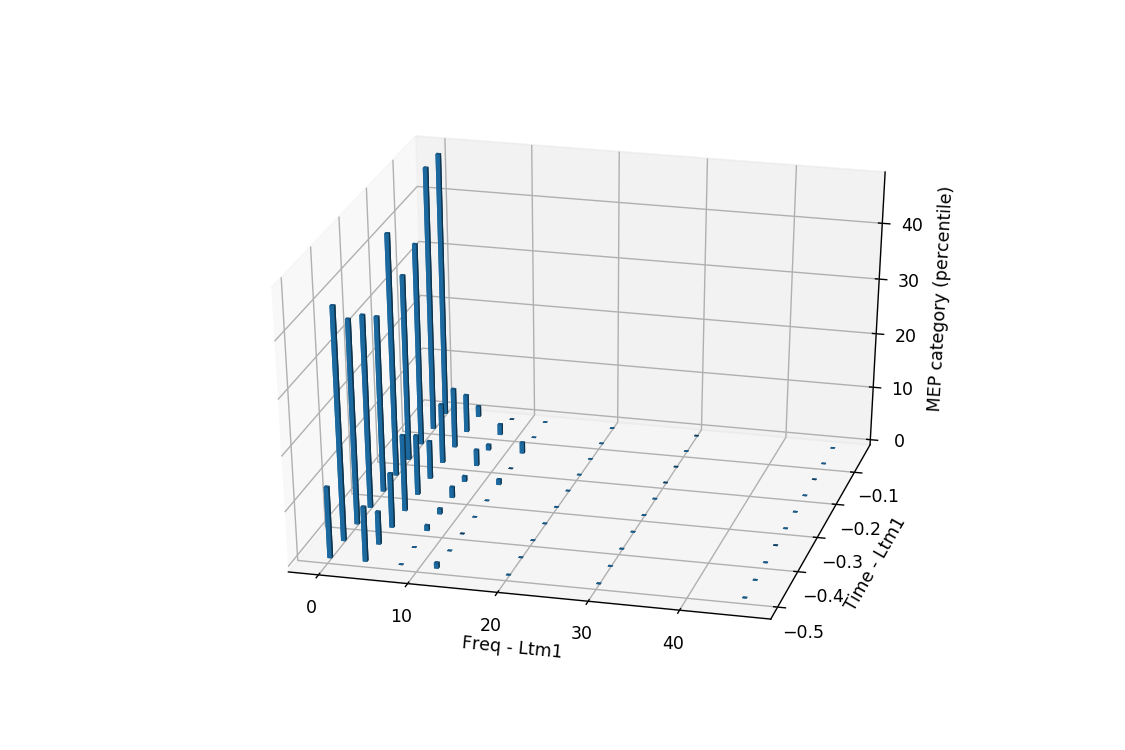

In [12]:
df_percentile_small = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_small = groupby_freq_time(df_percentile_small)
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_at_time_bin_left'], np.zeros_like(df_percentile_small['all_all_max_amplitude']), 0.5, 0.005, df_percentile_small['all_all_max_amplitude'], shade=True)
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Time - Ltm1')
ax.set_zlabel('MEP category (percentile)');

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


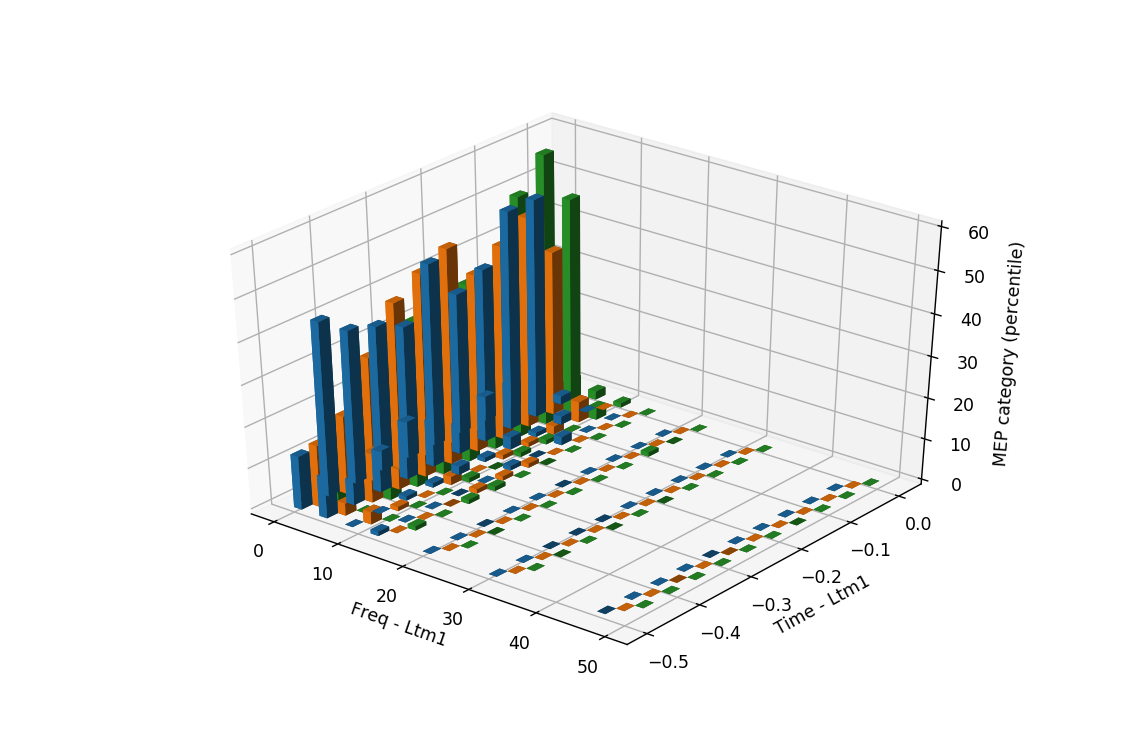

In [14]:
df_percentile_small = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_small = groupby_freq_time(df_percentile_small)

df_percentile_medium = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 1]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_medium = groupby_freq_time(df_percentile_medium)

df_percentile_large = categorize_by_freq_time(df2[df2['mep_category_percentile'] == 2]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_large = groupby_freq_time(df_percentile_large)


time_width = 0.02
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_at_time_bin_left'], np.zeros_like(df_percentile_small['all_all_max_amplitude']), freq_width, time_width, df_percentile_small['all_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin_left'] + freq_width, df_percentile_medium['wavelet_ltm1_max_power_at_time_bin_left'] + time_width, np.zeros_like(df_percentile_medium['all_all_max_amplitude']), freq_width, time_width, df_percentile_medium['all_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_large['wavelet_ltm1_max_power_at_freq_bin_left'] + freq_width * 2, df_percentile_large['wavelet_ltm1_max_power_at_time_bin_left'] + time_width * 2, np.zeros_like(df_percentile_large['all_all_max_amplitude']), freq_width, time_width, df_percentile_large['all_all_max_amplitude'], shade=True)
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Time - Ltm1')
ax.set_zlabel('MEP category (percentile)');

In [ ]:
df_percentile_small = categorize_by_freq_time(df2[df2['mep_category_absolute'] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_small = groupby_freq_time(df_percentile_small)

df_percentile_medium = categorize_by_freq_time(df2[df2['mep_category_absolute'] == 1]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_medium = groupby_freq_time(df_percentile_medium)

df_percentile_large = categorize_by_freq_time(df2[df2['mep_category_absolute'] == 2]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_large = groupby_freq_time(df_percentile_large)


time_width = 0.02
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_at_time_bin_left'], np.zeros_like(df_percentile_small['all_all_max_amplitude']), freq_width, time_width, df_percentile_small['all_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin_left'] + freq_width, df_percentile_medium['wavelet_ltm1_max_power_at_time_bin_left'] + time_width, np.zeros_like(df_percentile_medium['all_all_max_amplitude']), freq_width, time_width, df_percentile_medium['all_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_large['wavelet_ltm1_max_power_at_freq_bin_left'] + freq_width * 2, df_percentile_large['wavelet_ltm1_max_power_at_time_bin_left'] + time_width * 2, np.zeros_like(df_percentile_large['all_all_max_amplitude']), freq_width, time_width, df_percentile_large['all_all_max_amplitude'], shade=True)
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Time - Ltm1')
ax.set_zlabel('MEP category (absolute)');

# Plot Frequency vs MEP Area

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Area')

plt.figure(figsize=(14,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_area'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Area')

In [ ]:
df2 = df.groupby(['sub', 'exp', 'run']).mean()
df2.head()

In [ ]:
df2.shape

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_all_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('LtM1 Frequency (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_alpha_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('LtM1 Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

# Frequency bins

In [ ]:
bins = [0, 4, 8, 12, 20, 30, 46, 70]
df3_mean = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).mean()
df3_max = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).max()
df3_min = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).min()
df3_mean['mep_size_mean'] = df3_mean['mep_size']
df3_mean['mep_size_max'] = df3_max['mep_size']
df3_mean['mep_size_min'] = df3_min['mep_size']
df3_mean['rtm1_all_max_power_freq'] = df3_mean.index

In [ ]:
df3_mean[['rtm1_all_max_power_freq', 'mep_size_mean', 'mep_size_max', 'mep_size_min']]

In [ ]:
df4 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Left M1 Electrode Frequency Bins vs MEP Size')

df4 = df
df4['bin'] = pd.cut(df4['rtm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Right M1 Electrode Frequency Bins vs MEP Size')

df4 = df
df4['bin'] = pd.cut(df4['all_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('All Electrodes Frequency Bins vs MEP Size')

df4 = df
df4['bin'] = pd.cut(df4['central_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Central Electrodes Frequency Bins vs MEP Size')

# 3D Plot

In [ ]:
# df2 = df
# df3 = []
# for row in df2:
#     row['']
#     df3.append()

df4 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

# MEP size group chart

In [ ]:
df5 = df4.groupby(['bin_str', 'mep_category']).count()
df5 = df5[['mep_area']]
df5 = df5.unstack()
df5.columns = ['small', 'medium', 'large']
df5 = df5.sort_index(axis=0)
df5['order'] = [0, 3, 4, 5, 1, 2]
df5 = df5.sort_values(by=['order'])
df5 = df5.drop('order', axis=1)
df5

In [ ]:
ax = df5.plot(kind='bar', figsize=(12,4), colormap='Accent')
ax.set_xlabel('Frequency')
ax.set_ylabel('Count')

plt.figure(figsize=(12,4))
plt.plot(df5.index, df5['small'], color='r', label='small')
plt.plot(df5.index, df5['medium'], color='k', label='medium')
plt.plot(df5.index, df5['large'], color='c', label='large')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.legend()

# EEG area and amplitude

In [ ]:
plt.plot(df4['area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - all electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['rtm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - right M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['ltm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - left M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['all_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - all electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['ltm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Left M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['rtm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Right M1 electrodes')
plt.ylabel('MEP Size')

# Linear Regression

In [ ]:
df.dtypes

In [ ]:
x = df[['all_all_max_power', 
        'all_all_max_power_freq', 'all_alpha_max_power',
        'all_alpha_max_power_freq', 'all_beta_max_power',
        'all_beta_max_power_freq', 'all_delta_max_power',
        'all_delta_max_power_freq', 'all_gamma_max_power',
        'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
        'all_theta_max_power_freq', 'area_under_eeg',
        
        'ltm1_all_max_power', 
        'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
        'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
        'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
        'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
        'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
        'ltm1_max_amplitude', 'ltm1_theta_max_power',
        'ltm1_theta_max_power_freq', 
        
        'rtm1_all_max_power',
        'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
        'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
        'rtm1_beta_max_power', 'rtm1_beta_max_power_freq',
        'rtm1_delta_max_power', 'rtm1_delta_max_power_freq',
        'rtm1_gamma_max_power', 'rtm1_gamma_max_power_freq',
        'rtm1_max_amplitude', 'rtm1_theta_max_power',
        'rtm1_theta_max_power_freq',

        'central_all_max_power',
        'central_all_max_power_freq', 'central_alpha_max_power',
        'central_alpha_max_power_freq', 'central_area_under_eeg',
        'central_beta_max_power', 'central_beta_max_power_freq',
        'central_delta_max_power', 'central_delta_max_power_freq',
        'central_gamma_max_power', 'central_gamma_max_power_freq',
        'central_max_amplitude', 'central_theta_max_power',
        'central_theta_max_power_freq']]
y = df['mep_size']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

In [ ]:
model = LinearRegression().fit(x_train, y_train)

In [ ]:
y_predicted = model.predict(x_test)
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print(r2)

In [ ]:
plt.plot(y_test, y_predicted, 'o')

# Random Forest

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

In [ ]:
rf = RandomForestRegressor(n_estimators = 5000, random_state = 42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, y_pred))

In [ ]:
plt.plot(y_test, y_pred, 'o')

# SVR

In [ ]:
from sklearn.svm import SVR

In [ ]:
clf = SVR()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, y_pred))
plt.plot(y_test, y_pred, 'o')

# TPOT

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_01_pipeline_accuracy_100.py')

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_02_pipeline_r2_100.py')

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_03_pipeline_r2_400.py')

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_03_pipeline_accuracy_400.py')

# Test pipeline

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

In [ ]:
exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_regression, percentile=7),
    StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=29, p=1, weights="distance")),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.25, min_samples_leaf=20, min_samples_split=15, n_estimators=100)),
    SelectPercentile(score_func=f_regression, percentile=48),
    RandomForestRegressor(bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=14, min_samples_split=16, n_estimators=100)
)

exported_pipeline.fit(x_train, y_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, exported_pipeline.predict(x_train)))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, exported_pipeline.predict(x_test)))